## Student Name: Muhammad Khubaib Akram

## Student ID: 23098929

# Imports

You should not import any further functionality. If you feel this is required to complete the task, please discuss with your moderator.

In [2]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.8 MB/s eta 0:00:00


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# imported to keep track of compute time if you wish
import sys
np.set_printoptions(threshold=sys.maxsize)
import time

In [4]:
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import confusion_matrix
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import learning_curve

# Provided code
The below code is not necessarily complete or applicable to all tasks. Read and understand the code so that you can use wisely and adapt as required.

In [5]:
def plot_margin(X, y, clf):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=plt.cm.Paired)


    # plot the decision function
    ax = plt.gca()
    ax.set_aspect(aspect=1)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # create grid to evaluate model
    xx = np.linspace(xlim[0], xlim[1], 30)
    yy = np.linspace(ylim[0], ylim[1], 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T
    Z = clf.decision_function(xy).reshape(XX.shape)

    # plot decision boundary and margins
    ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    # plot support vectors
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1], s=100,
               linewidth=1, facecolors='none', edgecolors='k')

To compare the SVM with a NN:

In [6]:
def plot_decisions(X, y, model):
    # define bounds of the domain
    min1, max1 = X[:, 0].min()-1, X[:, 0].max()+1
    min2, max2 = X[:, 1].min()-1, X[:, 1].max()+1
    # define the x and y scale
    x1grid = np.arange(min1, max1, 0.1)
    x2grid = np.arange(min2, max2, 0.1)
    # create all of the lines and rows of the grid
    xx, yy = np.meshgrid(x1grid, x2grid)
    # flatten each grid to a vector
    r1, r2 = xx.flatten(), yy.flatten()
    r1, r2 = r1.reshape((len(r1), 1)), r2.reshape((len(r2), 1))
    # horizontal stack vectors to create x1,x2 input for the model
    grid = np.hstack((r1,r2))
    # make predictions for the grid
    yhat = model.predict(grid)
    # reshape the predictions back into a grid
    zz = yhat.reshape(xx.shape)
    # plot the grid of x, y and z values as a surface
    plt.contourf(xx, yy, zz, cmap='Paired')
    # create scatter plot for samples from each class
    for class_value in range(2):
        # get row indexes for samples with this class
        row_ix = np.where(y == class_value)
        # create scatter of these samples
        plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')

In [7]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    #plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_errors = 1- train_scores
    test_errors = 1-test_scores

    train_errors_mean = np.mean(train_errors, axis=1)
    train_errors_std = np.std(train_errors, axis=1)
    test_errors_mean = np.mean(test_errors, axis=1)
    test_errors_std = np.std(test_errors, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_errors_mean - train_errors_std,
                     train_errors_mean + train_errors_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_errors_mean - test_errors_std,
                     test_errors_mean + test_errors_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_errors_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_errors_mean, 'o-', color="g",
             label="Test error")


    plt.legend(loc="best")
    return plt

This wrapper is required in below BayesSearchCV for a neural network to combine the two layer arguments (or more if you wish to experiment with more than two layers) into the single hidden_layer_sizes hyper-parameter.

In [8]:
class MLPWrapper(BaseEstimator, ClassifierMixin):

    def __init__(self, layer1=10, layer2=10):
        self.layer1 = layer1
        self.layer2 = layer2

    def fit(self, X, y):
        model = MLPClassifier(
            hidden_layer_sizes=[self.layer1, self.layer2],
            max_iter = 1000,
        )
        model.fit(X, y)
        self.model = model
        return self

    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        return self.model.score(X, y)

In [8]:
# Example use of BayesSearchCV to search a large search space whilst keeping compute requirements in check

optSVM1_lin = BayesSearchCV(
    svm.SVC(),
    {
      'C': Real(1e-3, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['linear']),
    },
    n_iter=100,
)

In [9]:
# Example use of BayesSearchCV with the MLPWrapper to vary the layer sizes

optNN1 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(1, 100),
        'layer2': Integer(1, 100)
    },
    n_iter=100,
)

# Solutions

## Task 1

In [10]:
import pandas as pd

train_data_df = pd.read_csv("dataset_1_train.csv")
display(train_data_df.head())
#train_data.columns = ['feature_1', 'feature_2', 'label']

# Separate the features and the target
X = train_data_df.iloc[:, 0:2].to_numpy()
y = train_data_df.iloc[:, -1].to_numpy()



,9.133853201691273238e-01,-1.310706092832616965e-01,1.000000000000000000e+00
0,-1.393895,-1.373790,0.0
1,-0.379568,1.404829,0.0
2,1.525722,-1.713379,1.0
3,1.444181,-0.622548,1.0
4,1.108897,-1.456433,1.0





Accuracy = 0.998 with C= 0.001
Number of Support Vectors = 830




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


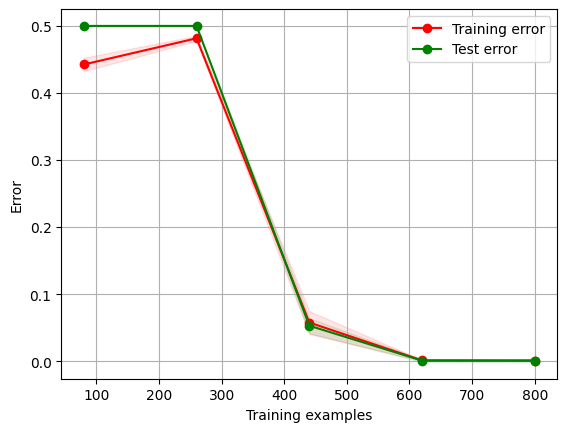

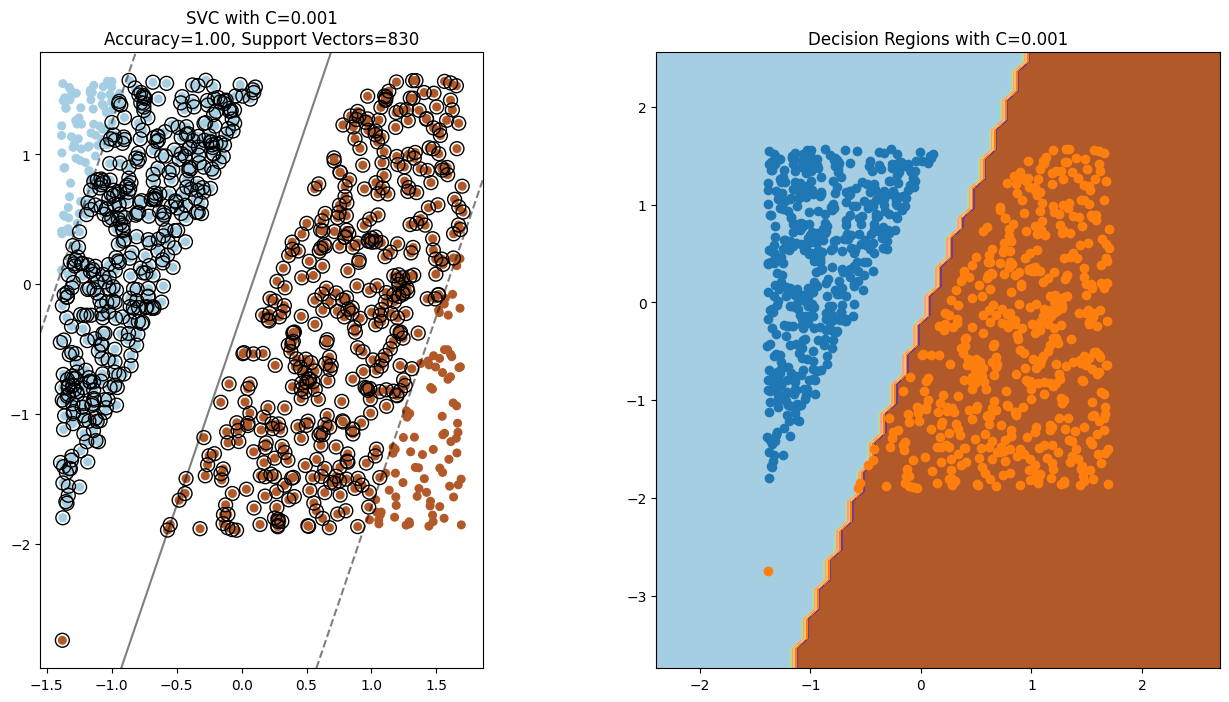




Accuracy = 0.999 with C= 0.075
Number of Support Vectors = 78




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


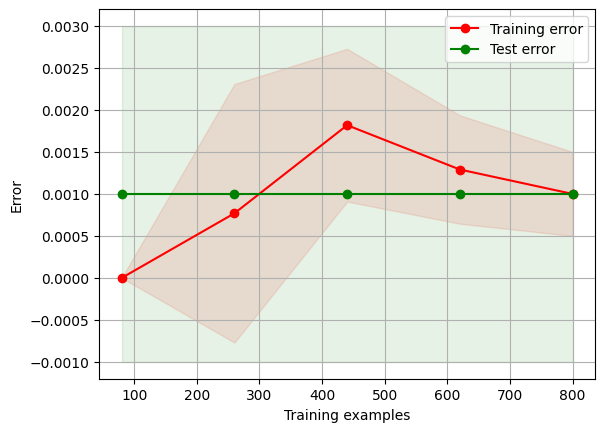

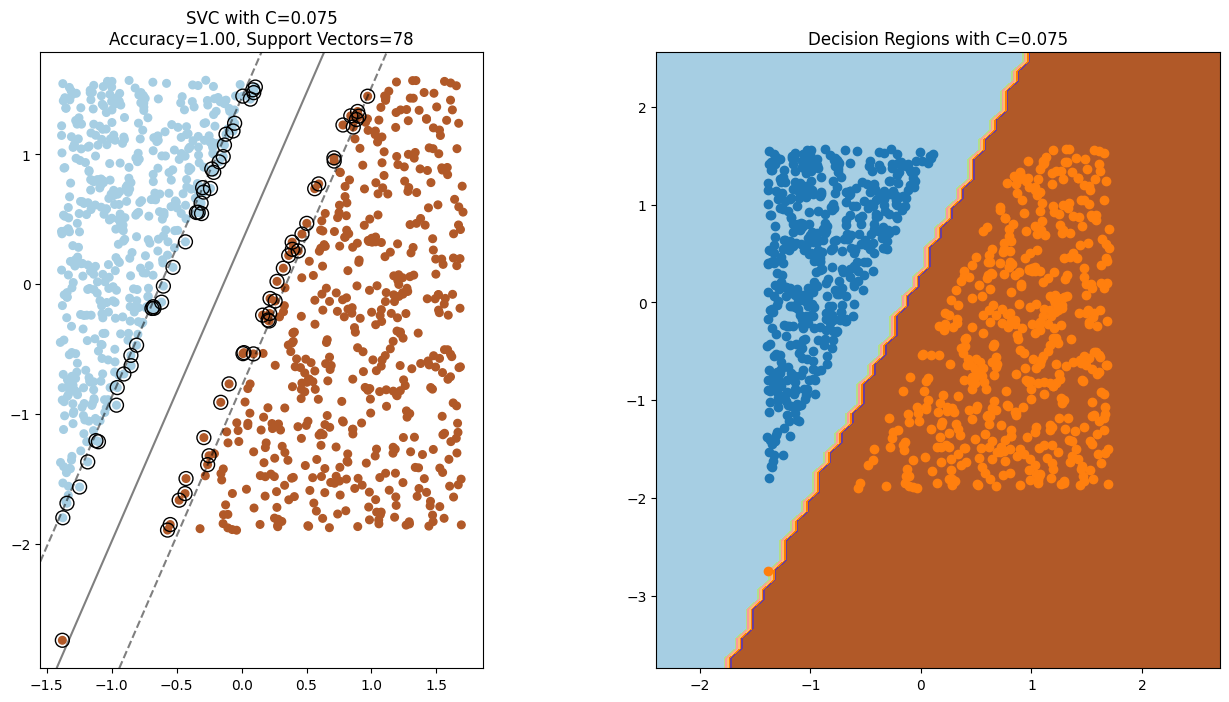




Accuracy = 1.000 with C= 0.2
Number of Support Vectors = 37




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


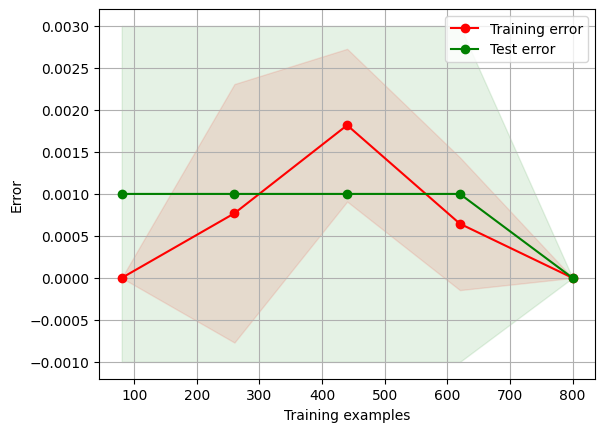

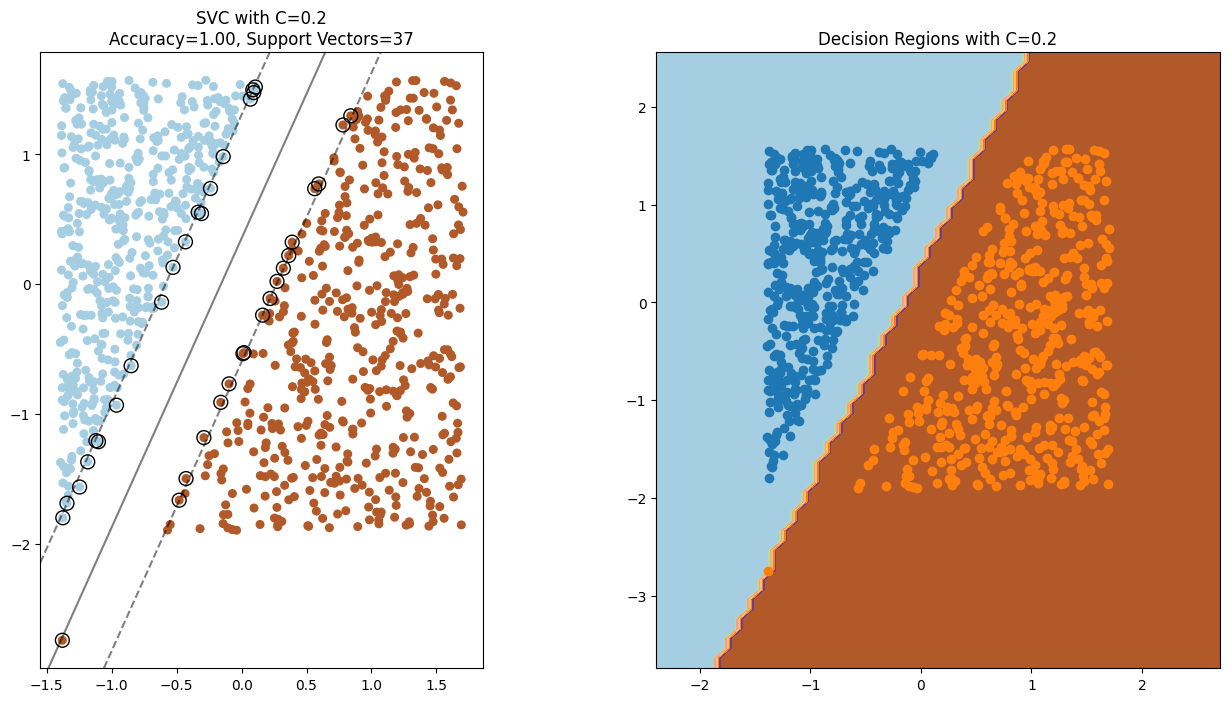




Accuracy = 0.999 with C= 1
Number of Support Vectors = 10




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


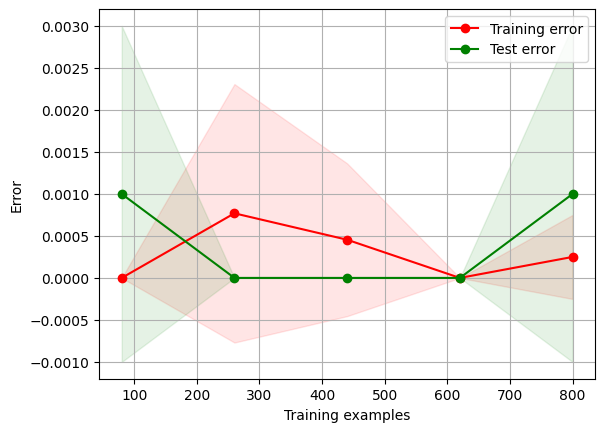

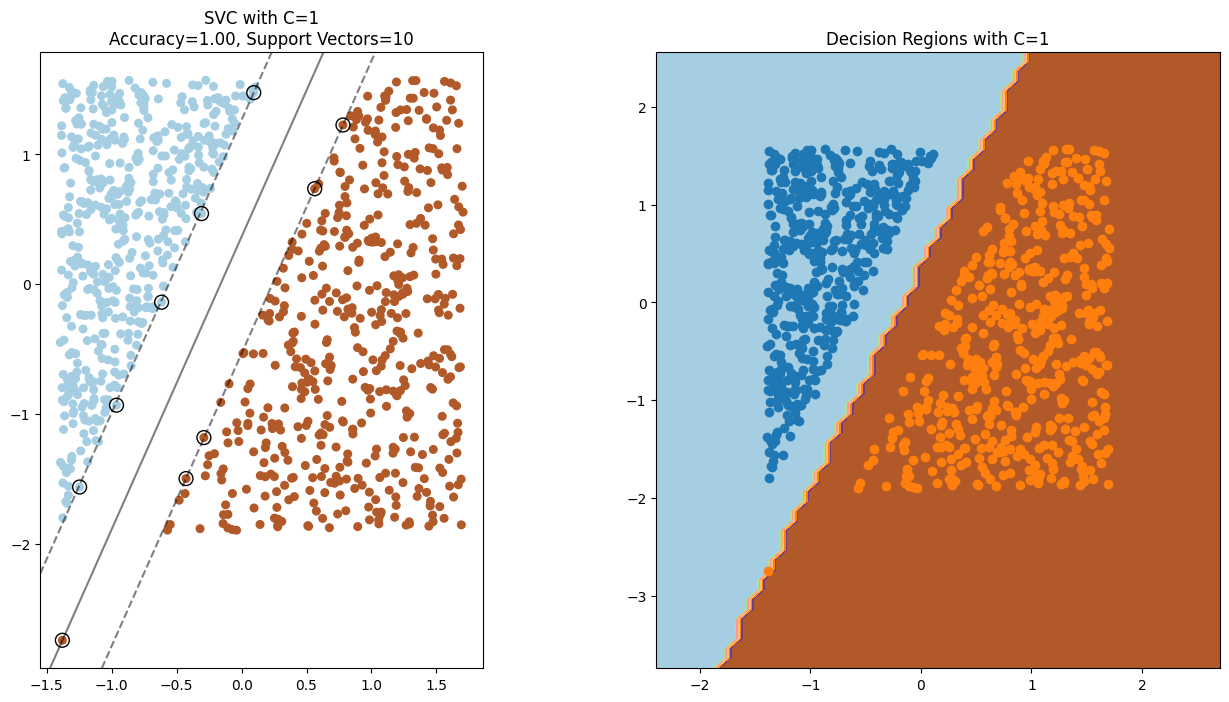




Accuracy = 1.000 with C= 4
Number of Support Vectors = 4




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


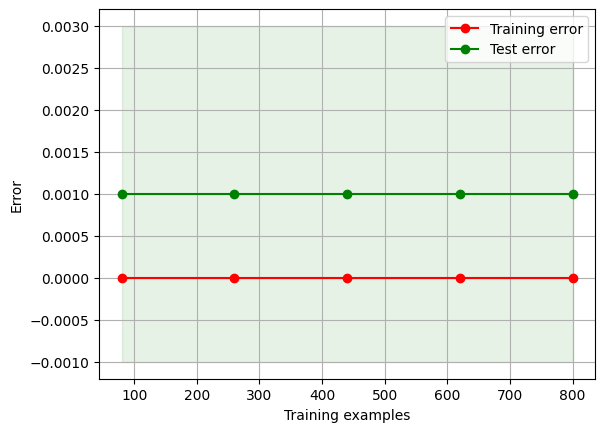

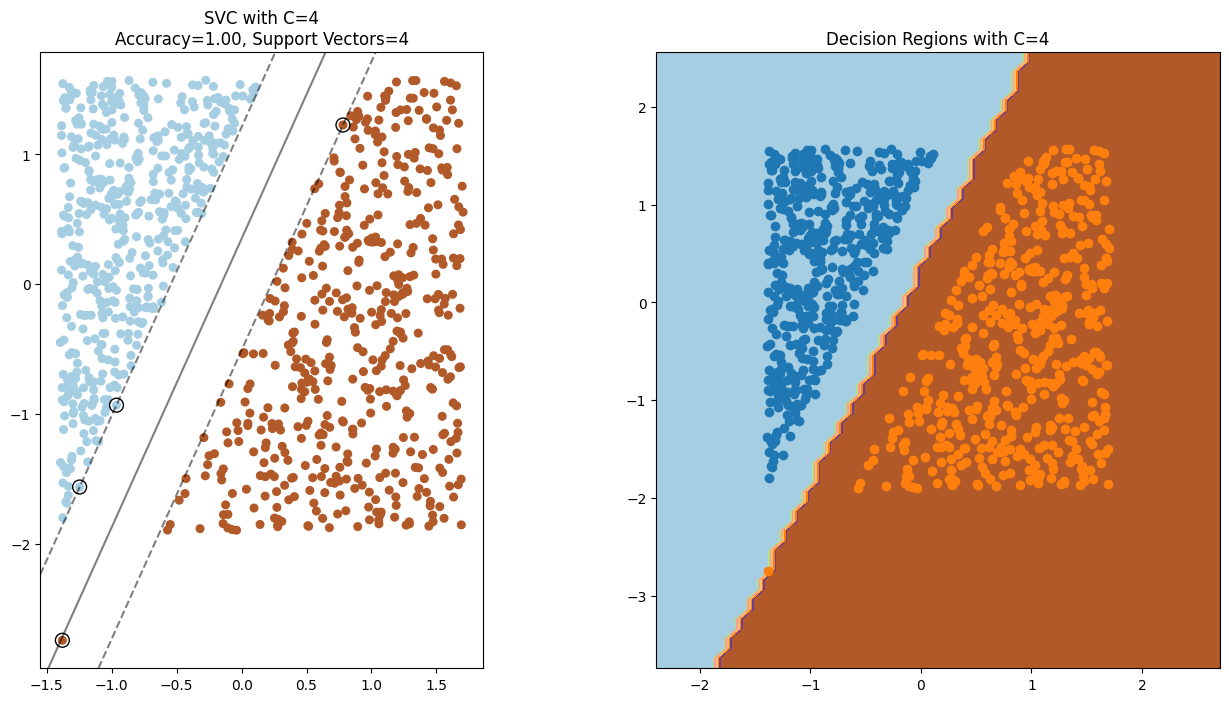




Accuracy = 1.000 with C= 10
Number of Support Vectors = 3




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


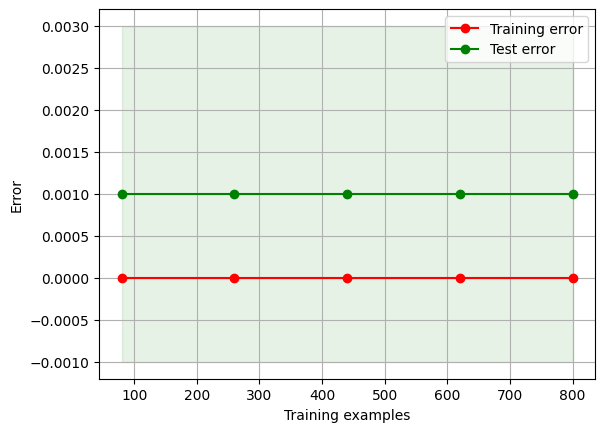

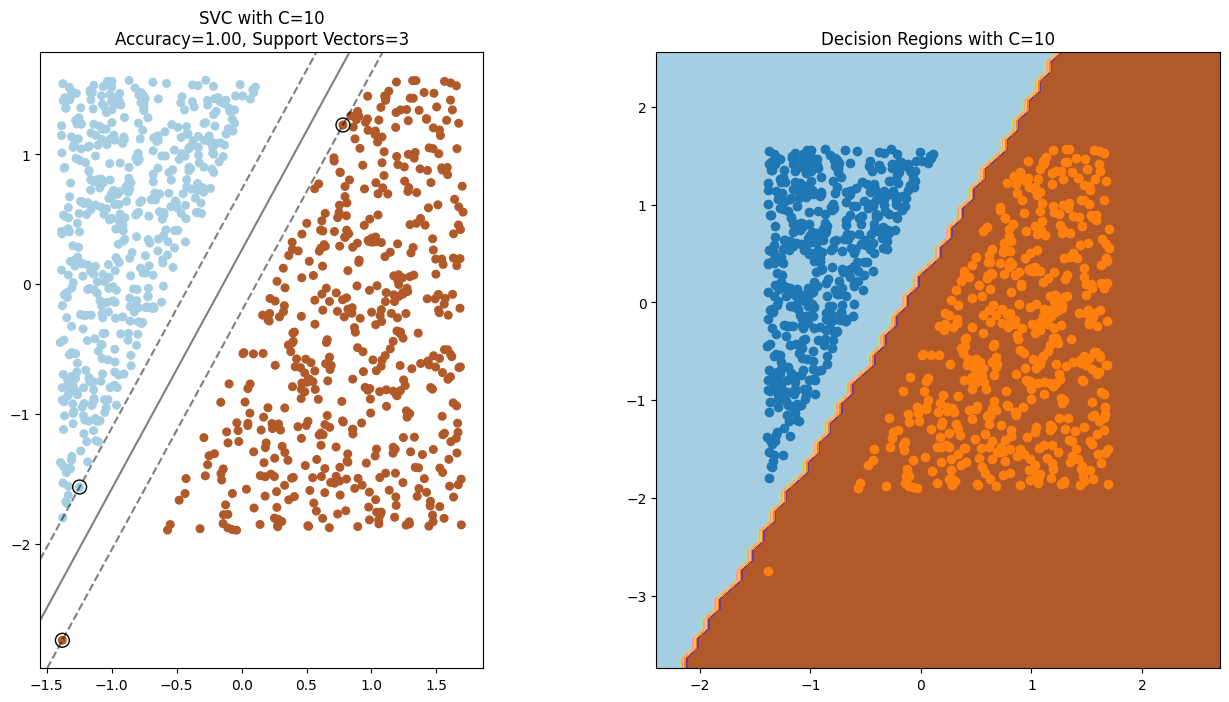




Accuracy = 1.000 with C= 100
Number of Support Vectors = 3




<ipython-input-5-4a88a4dcbac0>:26: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[row_ix, 0], X[row_ix, 1], cmap='Paired')


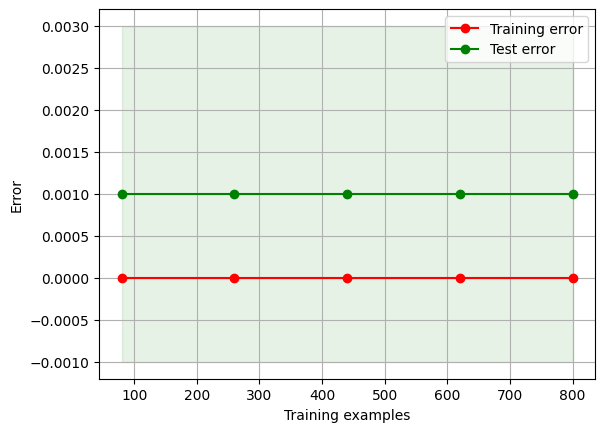

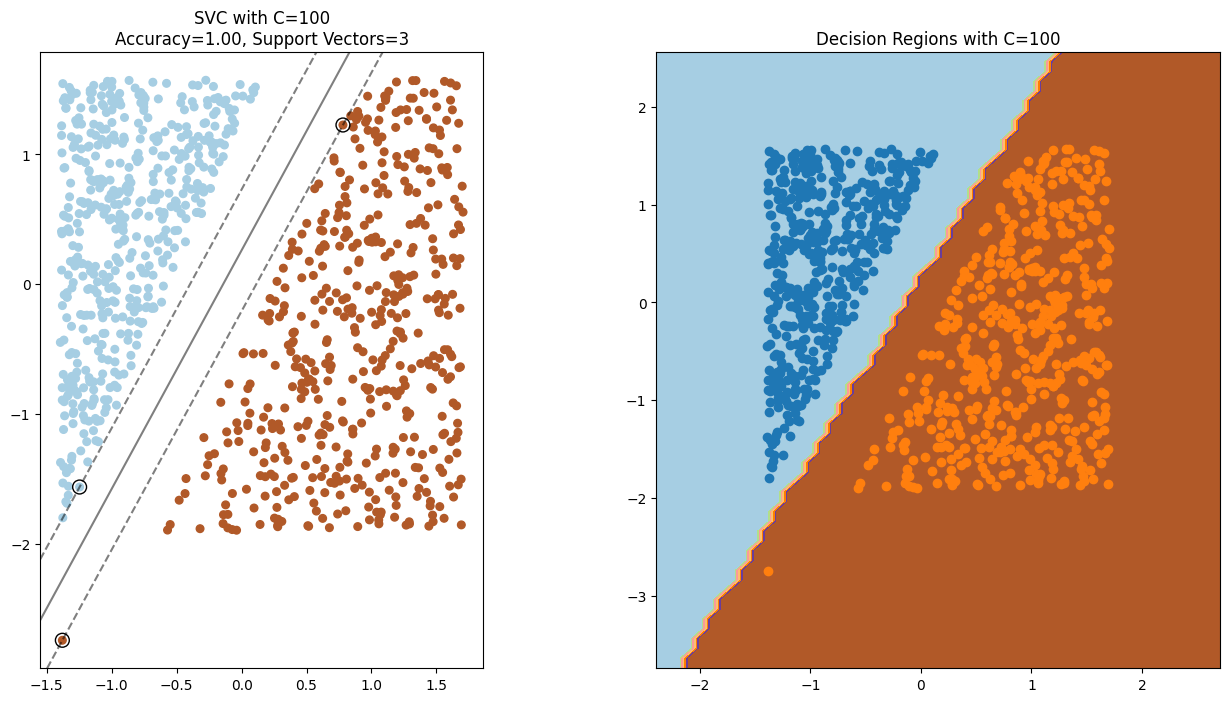

In [11]:

Cost= [ 0.001, 0.075, 0.2, 1, 4, 10,100]

for c in Cost:



    svc_cl_linear = svm.SVC(kernel='linear', C=c, random_state=42)
    svc_cl_linear.fit(X, y)

    accuracy_svc_cl = svc_cl_linear.score(X, y)
    num_support_vectors = len(svc_cl_linear.support_vectors_)

    print(f"\n\n\nAccuracy = {accuracy_svc_cl:.3f} with C= {c}")
    print(f"Number of Support Vectors = {num_support_vectors}")
    print()

    # plot for the learning curve
    plot_learning_curve(svc_cl_linear, f'Learning Curve for C={c}', X, y)
    print("")

    plt.figure(figsize=(16, 8))

    # subplot for the margins
    plt.subplot(1, 2, 1)
    plot_margin(X, y, svc_cl_linear)
    plt.title(f'SVC with C={c}\nAccuracy={accuracy_svc_cl:.2f}, Support Vectors={num_support_vectors}')

    # subplot for the decision regions
    plt.subplot(1, 2, 2)
    plot_decisions(X, y, svc_cl_linear)
    plt.title(f'Decision Regions with C={c}')
    plt.show()


I have used different values of C to show the effect on margins and classifications.

1. In SVM, a larger value of C corresponds to a hard margin which attempts to minimize the number of misclassified training examples but it can also lead to overfitting. A smaller value of C allows for more  misclassifications so providing a softer margin which can generalize better for out-of-sample data. Values such as
2. We Should select the optimal value of C as the high value of C leads to overfitting and very small value of C leads to underfitting. We need to make sure that it leads to generalize.
3. Large value of C leads to high variance and small bias meanwhile the small value of C leads to high bias and small variance.
4. The generalization capability of an SVM model is closely related to its margin. A wider margin with lower C values suggests that the model is less likely to overfit the training data because it is not trying to classify every training point correctly at the cost of simplicity. Such models may generalize better to unseen data because they focus on finding a decision boundary that separates the classes well on a broader scale, without being influenced heavily by individual data points or noise. On the other hand, with higher values of C results in a narrow margin showing that a model is too focused on correctly classifying every training point also including the potential outliers or noise. While this can lead to higher accuracy on the training data, it may also result in a model that does not perform as well on new, unseen data due to overfitting. In practice, its very important to find the optimal C value involves balancing the trade-off between bias and variance to achieve the best generalization performance.

# Task 2

In [11]:
# Load datasets
dataset_2_train = pd.read_csv("dataset_2_train.csv")
dataset_2_test = pd.read_csv("dataset_2_test.csv")
dataset_3_train = pd.read_csv("dataset_3_train.csv")
dataset_3_test = pd.read_csv("dataset_3_test.csv")

display(dataset_2_train.head())


,4.897631839093875561e-01,-1.319058960770343791e+00,1.000000000000000000e+00
0,1.218091,0.027041,1.0
1,-0.756690,-0.834019,1.0
2,-0.225763,0.500619,0.0
3,-1.465371,-0.932708,1.0
4,-0.351116,-0.107407,0.0


In [13]:
display(dataset_2_test.head())


,1.650663039708945901e+00,1.483684445591914924e+00,1.000000000000000000e+00
0,-1.358237,-0.456899,0.0
1,1.508070,1.613134,1.0
2,0.775682,-0.648303,1.0
3,-1.263360,0.381345,0.0
4,-1.363640,0.065905,0.0


#DataSet 2

In [12]:
X_train_2 = dataset_2_train.iloc[:, 0:2].values
y_train_2 = dataset_2_train.iloc[:, -1].values
X_test_2 = dataset_2_test.iloc[:, 0:2].values
y_test_2 = dataset_2_test.iloc[:, -1].values

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Scallign the dataset
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_2)
X_test_scaled = scaler.transform(X_test_2)


##SVM

In [18]:

from sklearn.svm import SVC

# Bayesian search for SVM
optSVM_2 = BayesSearchCV(
    SVC(),
    {
        'C': Real(1e-5, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['rbf', 'poly','sigmoid']),
        'gamma': Real(1e-5, 1e+1, prior='log-uniform'),  # Gamma is only used for 'rbf', 'poly' and 'sigmoid'
        'degree': Integer(1, 5)  # Degree is only used for 'poly'
    },
    n_iter=32,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    random_state=42
)

np.int = int
optSVM_2.fit(X_train_scaled, y_train_2)
print("Best parameters for the SVM on dataset 2:", optSVM_2.best_params_)


Best parameters for SVM on dataset 2: OrderedDict([('C', 1000.0), ('degree', 1), ('gamma', 0.024044299152932574), ('kernel', 'rbf')])


In [19]:
# Train SVM with the best parameters on dataset 2
best_svm_2 = SVC(**optSVM_2.best_params_)
best_svm_2.fit(X_train_scaled, y_train_2)

# Evaluate on test data
test_accuracy_svm_2 = best_svm_2.score(X_test_scaled, y_test_2)
print(f"Test Accuracy for the SVM on dataset 2: {test_accuracy_svm_2:.4f}\n")

Test Accuracy for SVM on dataset 2: 0.7606



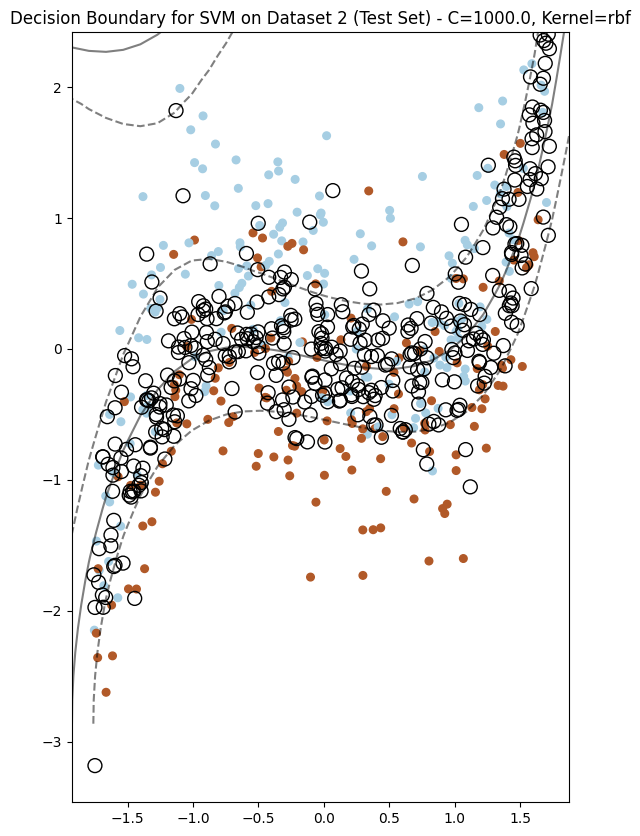

In [20]:
# Plot decision hyperplane and margins
plt.figure(figsize=(15, 10))
plot_margin(X_test_scaled, y_test_2, best_svm_2)
plt.title(f"Decision Boundary for SVM on Dataset 2 (Test Set) - C={optSVM_2.best_params_['C']}, Kernel={optSVM_2.best_params_['kernel']}")
plt.show()

<Figure size 800x600 with 0 Axes>

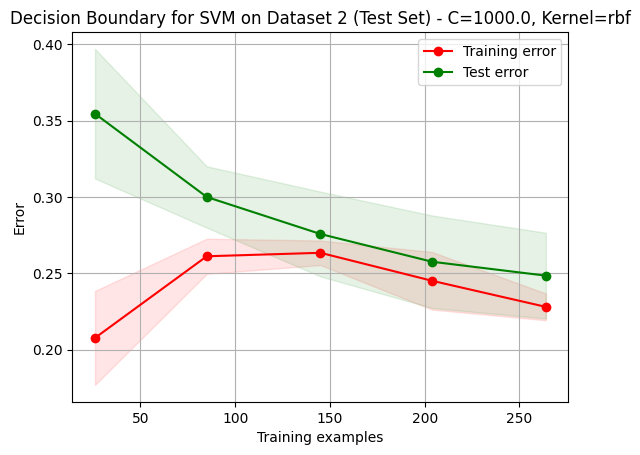

In [21]:

plt.figure(figsize=(8, 6))
plot_learning_curve(best_svm_2, f'Learning Curve for C={c}', X_test_scaled, y_test_2)
plt.title(f"Decision Boundary for SVM on Dataset 2 (Test Set) - C={optSVM_2.best_params_['C']}, Kernel={optSVM_2.best_params_['kernel']}")
plt.show()



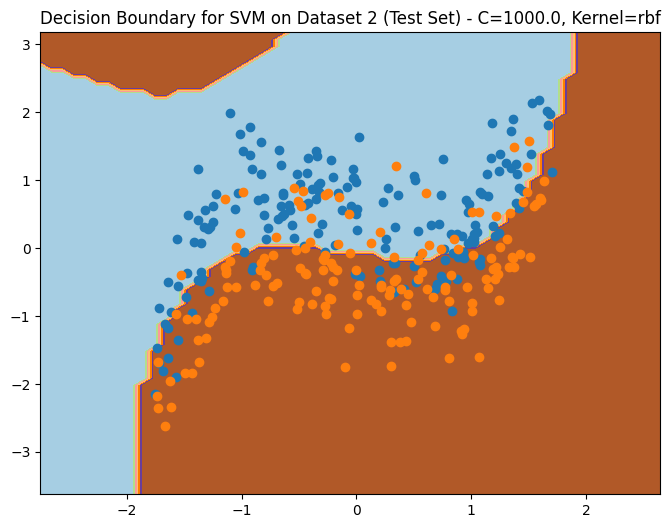

In [22]:
plt.figure(figsize=(8, 6))
plot_decisions(X_test_scaled, y_test_2, best_svm_2)
plt.title(f"Decision Boundary for SVM on Dataset 2 (Test Set) - C={optSVM_2.best_params_['C']}, Kernel={optSVM_2.best_params_['kernel']}")
plt.show()

The test accuracy for the SVM for data set 2 is around 76. Margin plot shows that the we had to select the C value hard. And it also shows that there were many support vectors as well.

Learning curver plot shows that the shaded areas around the error lines represent the variance in the error rates across different cross-validation folds. A broad shaded area on the test curve would indicate high variance in model performance on different subsets of the data.

You can see the decision boundary using the plot decision function.

#NN

In [23]:
# Setup Bayesian search for MLP
optNN_2 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(10, 100),
        'layer2': Integer(10, 100),
    },
    n_iter=100,
    cv=5,
    n_jobs=-1,
    random_state=42
)

np.int= int
optNN_2.fit(X_train_scaled, y_train_2)
print("Best parameters for MLP on dataset 2:", optNN_2.best_params_)


Best parameters for MLP on dataset 2: OrderedDict([('layer1', 10), ('layer2', 53)])


Test accuracy for optimized NN on dataset 2: 0.76


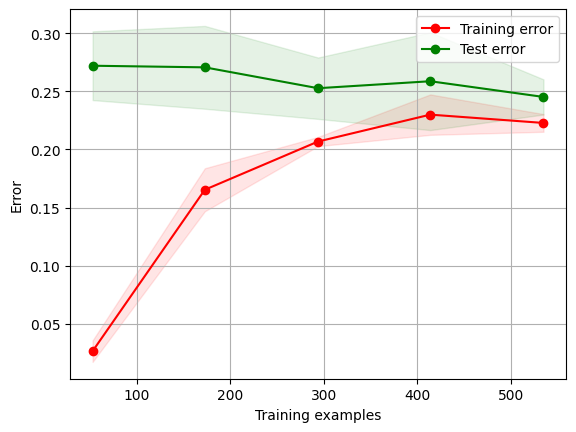

In [24]:
# Predict and evaluate on the test set
y_predNN_2 = optNN_2.predict(X_test_scaled)
accuracyNN_2 = accuracy_score(y_test_2, y_predNN_2)
print(f"Test accuracy for optimized NN on dataset 2: {accuracyNN_2:.2f}")

# Visualize the learning curve
plot_learning_curve(optNN_2.best_estimator_, "Learning Curve for Optimized NN on Dataset 2", X_train_scaled, y_train_2, cv=5, n_jobs=-1)
plt.show()

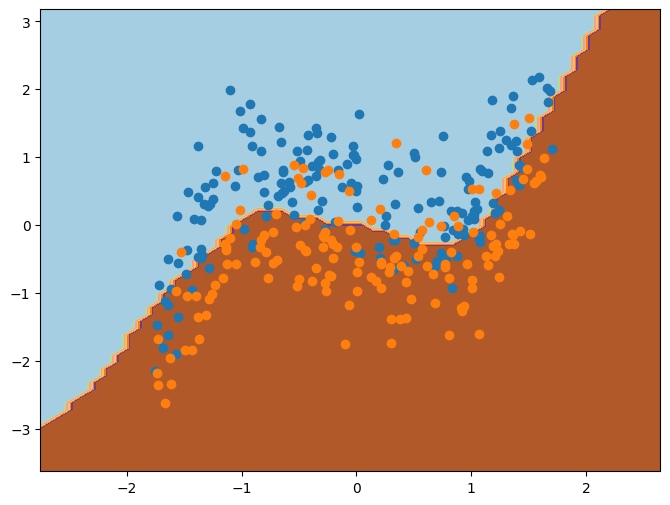

In [25]:
plt.figure(figsize=(8, 6))
plot_decisions(X_test_scaled, y_test_2, optNN_2.best_estimator_)
plt.show()

#DATASET 3


In [14]:
# Extracting features and targets for dataset 2
X_train_3 = dataset_3_train.iloc[:, 0:2].values
y_train_3 = dataset_3_train.iloc[:, -1].values
X_test_3 = dataset_3_test.iloc[:, 0:2].values
y_test_3 = dataset_3_test.iloc[:, -1].values

#scalling the dataset
X_train_3_scaled = scaler.fit_transform(X_train_3)
X_test_3_scaled= scaler.transform(X_test_3)


#SVM for Dataset 3

In [32]:

# Bayesian search for SVM
optSVM_3 = BayesSearchCV(
    SVC(),
    {
        'C': Real(1e-5, 1e+3, prior='log-uniform'),
        'kernel': Categorical(['rbf', 'poly','sigmoid']),
        'gamma': Real(1e-5, 1e+1, prior='log-uniform'),  # gamma is only used for 'rbf', 'poly' and 'sigmoid'
        'degree': Integer(1, 5)  # Degree is only used for 'poly'
    },
    n_iter=32,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,
    random_state=42
)

# Execute the search for best parameters
np.int = int
optSVM_3.fit(X_train_3_scaled, y_train_3)
print("Best parameters for SVM on dataset 3:", optSVM_3.best_params_)


# Train SVM with the best parameters on dataset 3
best_svm_3 = SVC(**optSVM_3.best_params_)
best_svm_3.fit(X_train_3_scaled, y_train_3)

# Evaluate on the test data
test_accuracy_svm_3 = best_svm_3.score(X_test_3_scaled, y_test_3)
print(f"Test Accuracy for the SVM on dataset 3: {test_accuracy_svm_3:.4f}\n")

Best parameters for SVM on dataset 3: OrderedDict([('C', 0.14397047336573615), ('degree', 4), ('gamma', 2.410259449561533), ('kernel', 'poly')])
Test Accuracy for SVM on dataset 3: 0.9634



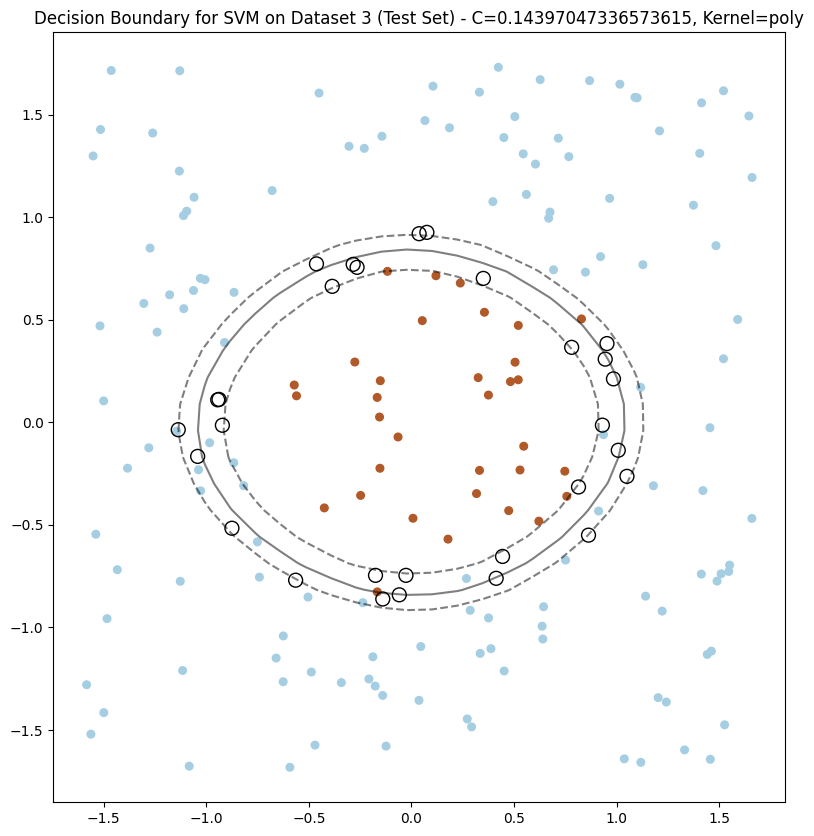

In [33]:
# Plot decision hyperplane and margins
plt.figure(figsize=(15, 10))
plot_margin(X_test_3_scaled, y_test_3, best_svm_3)
plt.title(f"Decision Boundary for SVM on Dataset 3 (Test Set) - C={optSVM_3.best_params_['C']}, Kernel={optSVM_3.best_params_['kernel']}")
plt.show()

<Figure size 800x600 with 0 Axes>

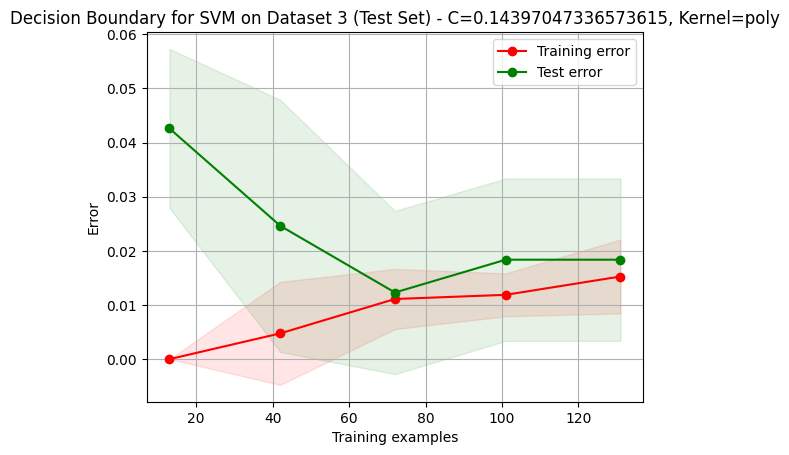

In [34]:

plt.figure(figsize=(8, 6))
plot_learning_curve(best_svm_3, f'Learning Curve for C={c}', X_test_3_scaled, y_test_3)
plt.title(f"Decision Boundary for SVM on Dataset 3 (Test Set) - C={optSVM_3.best_params_['C']}, Kernel={optSVM_3.best_params_['kernel']}")
plt.show()



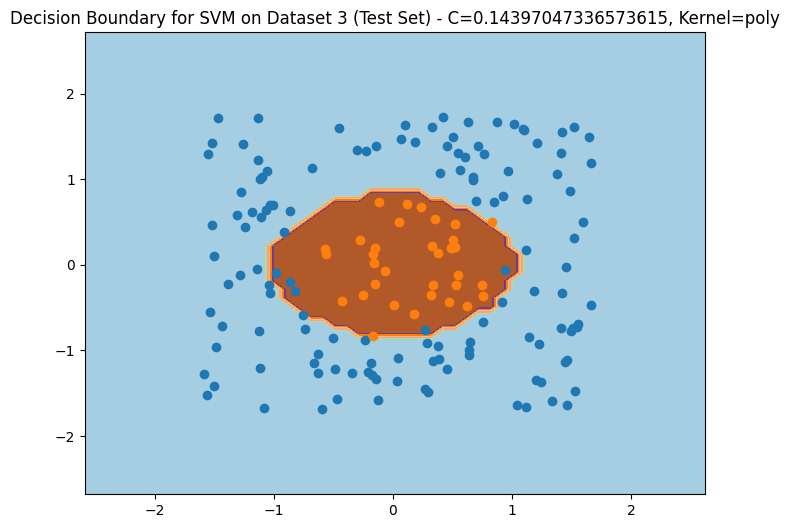

In [35]:
plt.figure(figsize=(8, 6))
plot_decisions(X_test_3_scaled, y_test_3, best_svm_3)
plt.title(f"Decision Boundary for SVM on Dataset 3 (Test Set) - C={optSVM_3.best_params_['C']}, Kernel={optSVM_3.best_params_['kernel']}")
plt.show()

#NN for Dataset 3

In [18]:
# Bayesian search for MLP
optNN_3 = BayesSearchCV(
    estimator=MLPWrapper(),
    search_spaces={
        'layer1': Integer(10, 100),
        'layer2': Integer(10, 100),
    },
    n_iter=100,
    cv=5,
    n_jobs=-1,
    random_state=42
)


np.int= int
optNN_3.fit(X_train_3_scaled, y_train_3)
print("Best parameters for MLP on dataset 2:", optNN_3.best_params_)


Best parameters for MLP on dataset 2: OrderedDict([('layer1', 79), ('layer2', 10)])


Test accuracy for optimized NN on dataset 3: 0.98


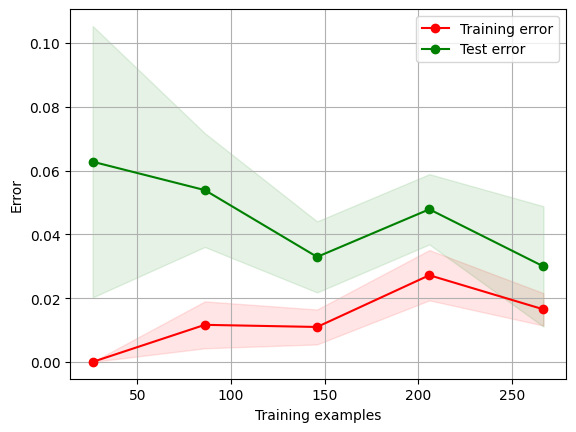

In [19]:
# Predict and evaluate on the test set
y_pred_nn_3 = optNN_3.predict(X_test_3_scaled)
accuracy_nn_3 = accuracy_score(y_test_3, y_pred_nn_3)
print(f"Test accuracy for optimized NN on dataset 3: {accuracy_nn_3:.2f}")

# Visualize the learning curve
plot_learning_curve(optNN_3.best_estimator_, "Learning Curve for Optimized NN on Dataset 3", X_train_3_scaled, y_train_3, cv=5, n_jobs=-1)
plt.show()

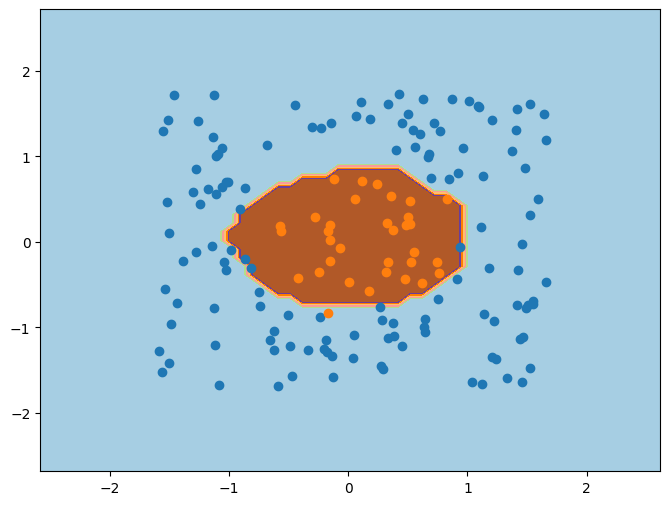

In [20]:
plt.figure(figsize=(8, 6))
plot_decisions(X_test_3_scaled, y_test_3, optNN_3.best_estimator_)
plt.show()


I used the Bayasian search to find the best parameters for SVM and to find the best accuracy in the NN on the specific layers.

1.   **Dataset 2**:
  * SVM: Best parameters for SVM on dataset 2: C= 1000.0, degree= 1 and gamma=0.024044299152932574 with kernel= rbf.
  Test Accuracy for SVM on dataset 2: 0.7606
  
  * NN: Best parameters for MLP on dataset 2: On these layers [('layer1', 10), ('layer2', 53)]) we got the test accuracy= 0.76

2.   **Dataset 3**:
  * SVM: Best parameters for SVM on dataset 3: C= 0.14397047336573615, degree= 4, gamma= 2.410259449561533, kernel= poly
  Test Accuracy for SVM on dataset 3: 0.9634

  * NN:   Best parameters for MLP on dataset 3: on these layers [('layer1', 79), ('layer2', 10)] we got the test accuracy= 0.98


NOTE: The accuracy would certainly be much better If I had the resouces on my laptop to go for much bigger iterations. I kept running into issues that my laptop got stuck on multiple occasions. Due to that I moved forward with less iterations in the bayesanSearch CV.


## Reflection


As the large value of C leads to higher variance and smaller bias, as we penalize the model more for misclassifying any point, which helps on the in-sample data, but here the trade-off is that our model becomes more complex.